In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import re
import numpy as np
from collections import Counter
import datetime
plt.style.use('ggplot')
from matplotlib import style
import csv
import os
import numpy
import copy
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import NMF, PCA
import matplotlib as mpl
from collections import Counter, defaultdict, OrderedDict
#from gensim import corpora, models, similarities, matutils
#from gensim.corpora.dictionary import Dictionary
from pandas import DataFrame, Series
import matplotlib
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline



import scipy as sp;
import sklearn;
import sys;
from nltk.corpus import stopwords;
import nltk;
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
#from gensim.models import ldamodel
#import gensim.corpora;
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer;
from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;
import pickle;

from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline


import pandas as pd
import csv
import os
import numpy
import copy
%matplotlib inline
import numpy as np
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#from gensim import corpora, models, similarities, matutils
#from gensim.corpora.dictionary import Dictionary
from sklearn.cluster import DBSCAN
from sklearn.decomposition import NMF, PCA
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter, defaultdict, OrderedDict
import seaborn as sns
import matplotlib.pyplot as plt















%matplotlib inline
dataset = pd.read_csv("/Users/natha/Documents/tweets1/tweets.csv", parse_dates=['time'], infer_datetime_format=True)

def tsimple(x):
    return datetime.datetime(x.year, x.month, x.day)

dataset['time'] = dataset.time.apply(tsimple)



Unique tweets: 17410
All tweets: 17410


[Text(0, 0, 'Actual Tweets'), Text(0, 0, 'Retweets')]

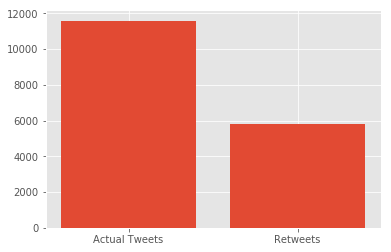

In [22]:
print("Unique tweets: {}".format(len(dataset['tweets'].unique())))
print("All tweets: {}".format(len(dataset['tweets'])))

retweets = []
actual_tweets = []
for user, tweet in zip(dataset['username'], dataset['tweets']):
    match = re.search(r'^\bRT\b', tweet)
    if match == None:
        actual_tweets.append([user,tweet])
    else:
        retweets.append([user,tweet])   

actual_tweets = np.array(actual_tweets)
retweets = np.array(retweets)

plt.bar([1,2], [len(actual_tweets[:,1]), len(retweets[:,1])], align='center')
ax = plt.gca()
ax.set_xticks([1,2])
ax.set_xticklabels(['Actual Tweets', 'Retweets'])

Text(0.5, 1.0, 'Mentioned vs. Total in tweets.csv')

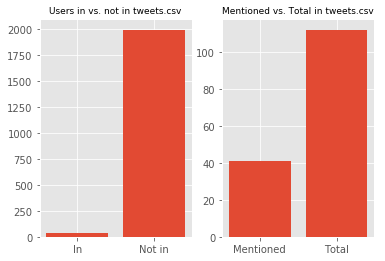

In [23]:
in_set = []
not_in_set = []
for record in actual_tweets:
    match = re.findall(r'@\w*', record[1])
    if match != []:
        for name in match:
            if (name[1:] in dataset['username'].unique()) and (record[0] != name[1:]):
                in_set.append([record[0], name[1:]])
            elif record[0] != name[1:]:
                not_in_set.append([record[0], name[1:]])

in_set = np.array(in_set)
not_in_set = np.array(not_in_set)

fig, ax = plt.subplots(1,2)

ax[0].bar([1,2], [len(np.unique(in_set[:,1])), len(np.unique(not_in_set[:,1]))], align='center')
ax[0].set_xticks([1,2])
ax[0].set_xticklabels(['In', 'Not in'])
ax[0].set_title('Users in vs. not in tweets.csv', fontsize=9)

ax[1].bar([1,2], [len(np.unique(in_set[:,1])), len(dataset['username'].unique())], align='center')
ax[1].set_xticks([1,2])
ax[1].set_xticklabels(['Mentioned', 'Total'])
ax[1].set_title('Mentioned vs. Total in tweets.csv', fontsize=9)


In [24]:
sender_count = Counter(in_set[:,0])
receiver_count = Counter(in_set[:,1])
top_5_senders = sender_count.most_common(5)
top_5_receivers = receiver_count.most_common(5)

print(top_5_senders)
print(top_5_receivers)


[('MaghrabiArabi', 49), ('WarReporter1', 30), ('AsimAbuMerjem', 27), ('Uncle_SamCoco', 27), ('moustiklash', 20)]
[('RamiAlLolah', 53), ('Nidalgazaui', 34), ('MilkSheikh2', 26), ('WarReporter1', 15), ('_IshfaqAhmad', 15)]


In [25]:
for name, _ in top_5_receivers:
    print("Username: {} - {}\n".format(name,
            dataset[dataset['username'] == name]['description'].dropna().unique()[0]))


Username: RamiAlLolah - Real-Time News, Exclusives, Intelligence & Classified Information/Reports from the ME. Forecasted many Israeli strikes in Syria/Lebanon. Graphic content.

Username: Nidalgazaui - 17yr. old Freedom Activist
/Correspondence of NGNA /Terror Expert/Middle East Expert. Daily News about Syria/Iraq/Yemen/Russia/Middle East

Username: MilkSheikh2 - Muslim, Iraqi, Banu Zubid, Qahtani, Chef, Engineer, Remaining until the best of them, fights al-Dajjal, Translate Old stuff mostly

Username: WarReporter1 - Reporting on conflicts in the MENA and Asia regions.

Username: _IshfaqAhmad - Medico at GMC Srinagar • Pro-Khilafah • Anti-Democratic • Anti-Nationalistic • Anti-Rafidah • Innocent Bystander of the Conflict in Middle East • Cricketist •



In [28]:
graph = nx.Graph()

all_users = list(set(in_set[:,0]) | set(in_set[:,1]))
graph.add_nodes_from(all_users, count=10)
node_colours = []

for node in graph.nodes():
    if node in (set(in_set[:,0]) & set(in_set[:,1])):
        node_colours.append('g')
    elif node in np.unique(in_set[:,0]):
        node_colours.append('r')
    elif node in np.unique(in_set[:,1]):
        node_colours.append('b')


In [29]:
edges = {}
occurrence_count = Counter(map(tuple, in_set))
for (sender, receiver), count in occurrence_count.items():
    if (receiver, sender) in edges.keys():
        edges[(receiver, sender)] = edges[(receiver, sender)] + count
    else:
        edges[(sender, receiver)] = count
        
for (sender, receiver), count in edges.items():
    graph.add_edge(sender, receiver, weight=count)
    
followers = {}
tweet_num = {}
for username in all_users:
    followers[username] = dataset[dataset['username'] == username]['followers'].unique()[-1]
    tweet_num[username] = dataset[dataset['username'] == username]['tweets'].count()

sizes = [(followers[n] / tweet_num[n]) * 50 for n in graph.nodes()]
weights = [graph.edge[u][v]['weight']/2 for u, v in graph.edges()]

plt.figure(figsize=(20,20))
nx.draw(graph, pos=nx.spring_layout(graph),
        node_color=node_colours, with_labels=True, width=weights)
plt.show()

AttributeError: 'Graph' object has no attribute 'edge'

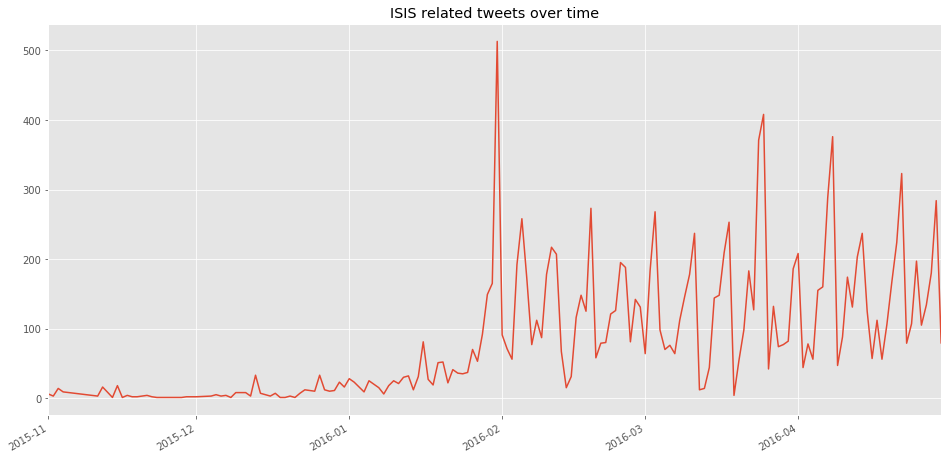

In [30]:
dataset.time.value_counts().plot(title='ISIS related tweets over time',
                              xlim=[datetime.date(2015, 11, 1),datetime.date(2016, 4, 30)],
                              figsize=(16,8))

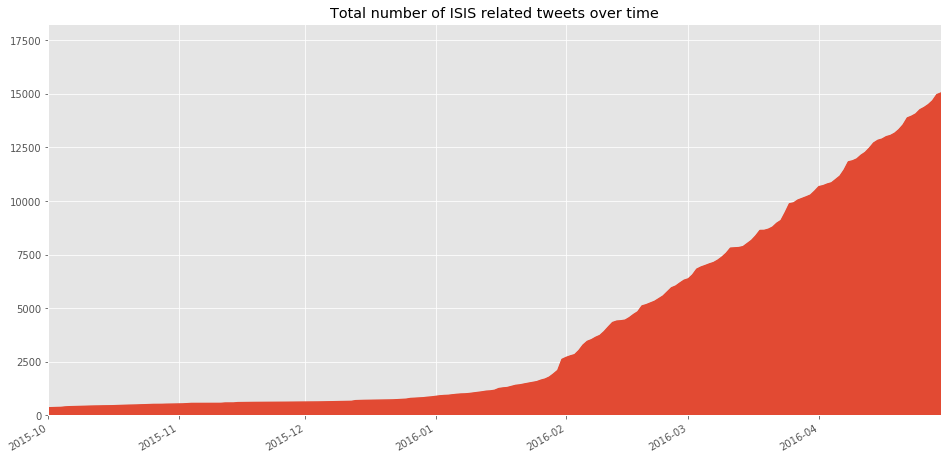

In [31]:
dataset.time.value_counts().sort_index().cumsum().plot.area(title='Total number of ISIS related tweets over time',
                                                         xlim=[datetime.date(2015, 10, 1),datetime.date(2016, 4, 30)],
                                                         figsize=(16,8))

In [32]:
time_tweets = dataset.time.value_counts().sort_index()
april_tweets = time_tweets.loc['2016-4-1':'2016-4-30']

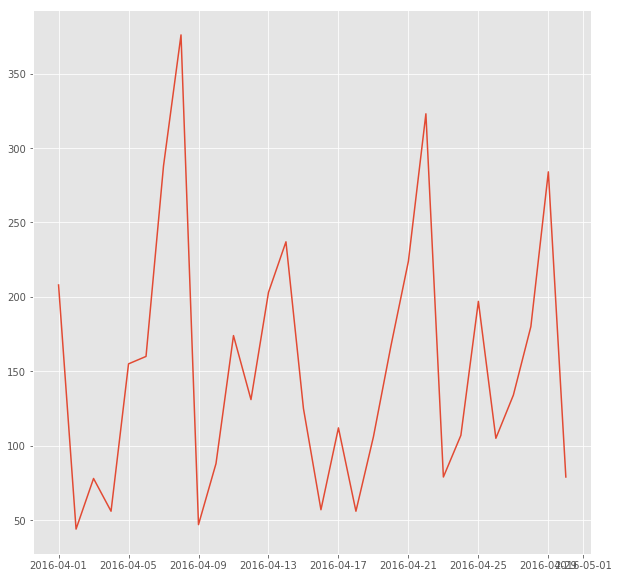

In [49]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
line = ax.plot(april_tweets)


plt.show()

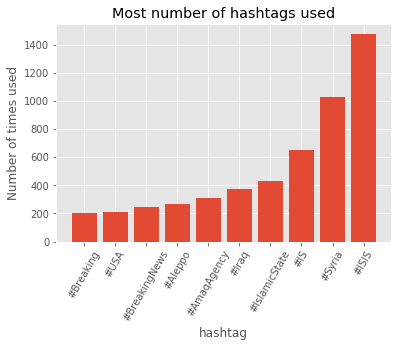

In [35]:
MyColumns = ['hashtag','cnt']
hashtagcount = pd.DataFrame(columns=MyColumns)

for index, row in dataset.iterrows():
    if "#" in row['tweets']:
        words = row['tweets'].split()
        for word in words:
            if word[0] == '#':
                hashtagcount.loc[len(hashtagcount)] = [word, 1]  # adding a row
                
hashtags = hashtagcount.groupby(['hashtag']).count().reset_index()
hashtags = hashtags.sort_values(by='cnt').tail(10)

x = hashtags['hashtag']
y = hashtags['cnt']
plt.xlabel('hashtag')
plt.ylabel('Number of times used')
plt.title('Most number of hashtags used')
plt.xticks(range(10), x, rotation=60)
plt.bar(range(10), y, label='Most hashtags used')
plt.show()

In [36]:
unique_tweeterites = dataset.groupby('username')
print(len(unique_tweeterites))

112


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017F5BF5A7B8>]],
      dtype=object)

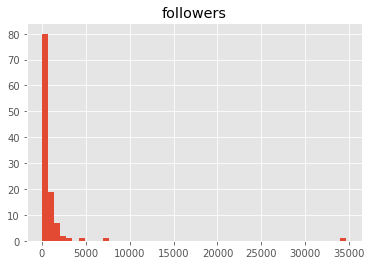

In [37]:
summum_popularity = pd.DataFrame(dataset.groupby('username').followers.max())
summum_popularity.hist(bins=50)

In [38]:
small=500
mid=2000
big=10000
summum_popularity['starhood']='none'
summum_popularity.loc[summum_popularity.followers<small,'starhood']='small'
summum_popularity.loc[(summum_popularity.followers>small) & (summum_popularity.followers<mid),'starhood']='mid'
summum_popularity.loc[(summum_popularity.followers>mid) & (summum_popularity.followers<big),'starhood']='large'
summum_popularity.loc[(summum_popularity.followers>big),'starhood']='very large'
dataset.set_index('username', inplace=True)
dataset['starhood']=summum_popularity.starhood
dataset.reset_index(inplace=True)

print(dataset.groupby('starhood').username.unique().apply(lambda x: x.size))

starhood
large          6
mid           31
small         74
very large     1
Name: username, dtype: int64


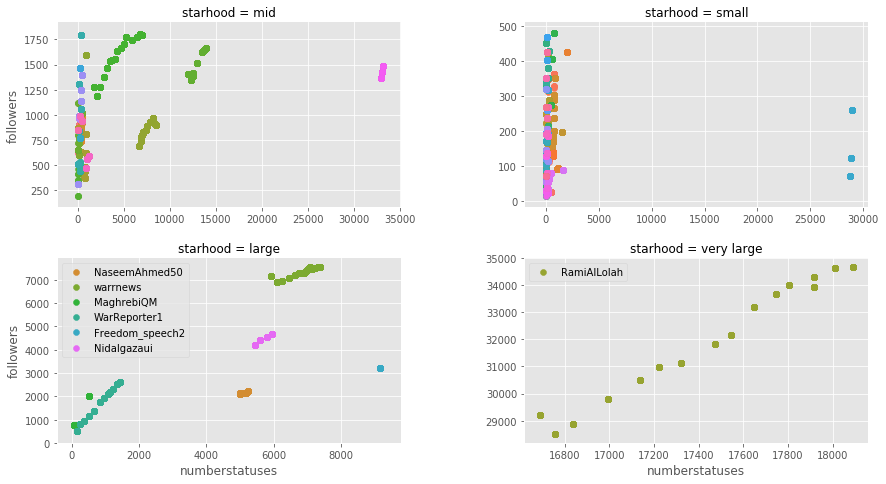

In [39]:
dataset[dataset.starhood=='large'].groupby('name').username.last()

dataset[dataset.starhood=='large'].groupby('name').username.last()

grid = sns.FacetGrid(data=dataset, col='starhood',col_wrap=2, hue='username', sharex=False, sharey=False)
grid=grid.map(plt.scatter,'numberstatuses','followers')
grid.axes[2].legend(loc='upper left')
grid.axes[3].legend(loc='upper left')
grid.fig.set_size_inches((14,7))

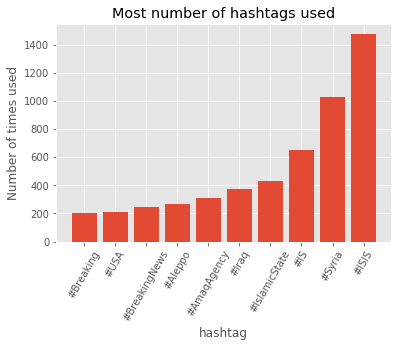

In [40]:
MyColumns = ['hashtag','cnt']
hashtagcount = pd.DataFrame(columns=MyColumns)

for index, row in dataset.iterrows():
    if '#' in row['tweets']:
        words = row['tweets'].split()
        for word in words:
            if word[0] == '#':
                hashtagcount.loc[len(hashtagcount)] = [word, 1]  # adding a row
                
hashtags = hashtagcount.groupby(['hashtag']).count().reset_index()
hashtags = hashtags.sort_values(by='cnt').tail(10)

x = hashtags['hashtag']
y = hashtags['cnt']
plt.xlabel('hashtag')
plt.ylabel('Number of times used')
plt.title('Most number of hashtags used')
plt.xticks(range(10), x, rotation=60)
plt.bar(range(10), y, label='Most hashtags used')
plt.show()